**Mount drive with colab**

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Check working directory**

In [50]:
#check present directory
!pwd

/content/drive/My Drive/Project_try/Mask_RCNN


**Change working directory to project directory**

In [51]:
import os
project_dir = '/content/drive/My Drive/Project_try'
# Change current directoty to mounted on gdrive
os.chdir(project_dir)
# check present directory
os.getcwd()

'/content/drive/My Drive/Project_try'

**Import Tensorflow**

In [52]:
%tensorflow_version 1.x

**Install and Import Keras supported version**

In [53]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.0

Uninstalling Keras-2.1.0:
  Successfully uninstalled Keras-2.1.0
  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.


**Clone Mask RCNN model from Matterplot**

In [ ]:
# Do this only at startup!!!
# !git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

**Clone Coco api**

In [ ]:
# Do this only at startup!!!
# !git clone https://github.com/cocodataset/cocoapi.git

%cd cocoapi/PythonAPI
!make
%cd ../../

**Set working directory to Mask RCNN folder**

In [54]:
cd /content/drive/My Drive/Project_try/Mask_RCNN

/content/drive/My Drive/Project_try/Mask_RCNN


**Import all supporting libaries requires for Mask RCNN**

In [55]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
#ROOT_DIR = os.path.abspath("../")
ROOT_DIR = os.path.abspath('/content/drive/My Drive/Project_try/Mask_RCNN/')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)



**Implement Configuration image**

In [57]:
class GlaucomaCupConfig(Config):
    # Give the configuration a recognizable name
    NAME = "Glaucoma_cup"
    
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 50

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM =  512
    IMAGE_MAX_DIM =  512
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000

   

config = GlaucomaCupConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

**Merge dataset to annotate file**

In [58]:
class GlaucomaDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'optic cup')
        self.add_class('dataset', 2, 'optic disc')
       
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
       
        masks = np.zeros([512, 512, len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            
            mask = np.zeros([512, 512], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

**Split Training and Validation set**

In [59]:
# Create training and validation set
# train set
dataset_train = GlaucomaDataset()
dataset_train.load_dataset('/content/drive/My Drive/Project_try/Dataset/Train')
dataset_train.prepare()
#print('Train: %d' % len(dataset_train.image_ids))

# test/val set
dataset_val = GlaucomaDataset()
dataset_val.load_dataset('/content/drive/My Drive/Project_try/Dataset/Val')
dataset_val.prepare()
#print('Test: %d' % len(dataset_val.image_ids))

Train: 1120
Test: 280


**Train Data Visualization**

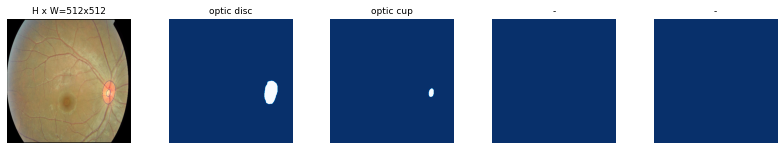

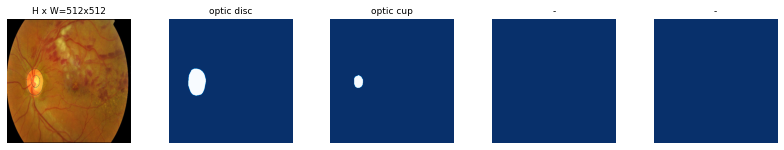

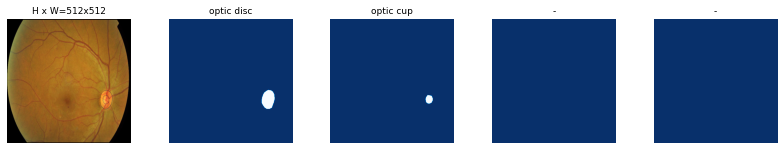

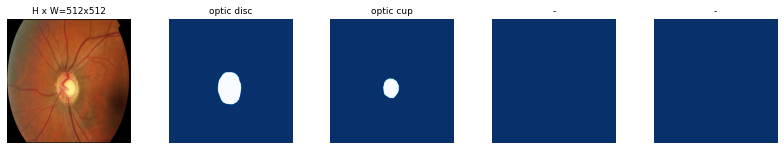

In [61]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

**Create Model**

In [62]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

**Create Model with callback function**

In [63]:
model_inference = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,model_inference, dataset_val, calculate_map_at_every_X_epoch=2, dataset_limit=10, verbose=1)

**Coco Weight**

In [64]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

**Train model**

In [ ]:
model._get_distribution_strategy = lambda: None
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=8, 
            layers='heads',
            #save_each_n_epoch=1,
            custom_callbacks=[mean_average_precision_callback])


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Project_try/Mask_RCNN/logs/glaucoma_cup20200804T1702/mask_rcnn_glaucoma_cup_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/8
199/200 [============================>.] - ETA: 0s - loss: 1.4482 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.6646 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.2954

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 281s 1s/step - loss: 1.4464 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.6649 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.3654 - mrcnn_mask_loss: 0.2946 - val_loss: 0.9547 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.5729 - val_mrcnn_class_loss: 0.0645 - val_mrcnn_bbox_loss: 0.1798 - val_mrcnn_mask_loss: 0.1303
Epoch 2/8
200/200 [==============================] - 86s 432ms/step - loss: 0.8996 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.1145 - val_loss: 0.7976 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.4940 - val_mrcnn_class_loss: 0.0907 - val_mrcnn_bbox_loss: 0.1133 - val_mrcnn_mask_loss: 0.0935
Epoch 3/8
200/200 [==============================] - 98s 490ms/step - loss: 0.6854 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.0980 - val_loss: 0.6463 - val_rpn_class_loss: 0.0

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 85s 426ms/step - loss: 0.5304 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.2776 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.0851 - val_loss: 0.5061 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.2935 - val_mrcnn_class_loss: 0.0469 - val_mrcnn_bbox_loss: 0.0835 - val_mrcnn_mask_loss: 0.0791
Epoch 6/8
199/200 [============================>.] - ETA: 0s - loss: 0.4599 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.0814Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /content/drive/My Drive/Project_try/Mask_RCNN/logs/glaucoma_cup20200804T1702/mask_rcnn_glaucoma_cup_0006.h5
Re-starting from epoch 6
mAP at epoch 6 is: 1.0
200/200 [==============================] - 90s 448ms/step - loss: 0.4608 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0749 - 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 86s 430ms/step - loss: 0.4506 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.2371 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.0857 - val_loss: 0.4373 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.2352 - val_mrcnn_class_loss: 0.0517 - val_mrcnn_bbox_loss: 0.0703 - val_mrcnn_mask_loss: 0.0773
Epoch 8/8
199/200 [============================>.] - ETA: 0s - loss: 0.3979 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0793Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /content/drive/My Drive/Project_try/Mask_RCNN/logs/glaucoma_cup20200804T1702/mask_rcnn_glaucoma_cup_0008.h5
Re-starting from epoch 8
mAP at epoch 8 is: 1.0
200/200 [==============================] - 90s 448ms/step - loss: 0.3968 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1989 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0639 - 

**Model Loss Graph**

In [ ]:
hist = model.keras_model.history.history


# Plot of training and validation losses for  mask, bbox, class and total loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist['mrcnn_bbox_loss'])
plt.plot(hist['val_mrcnn_bbox_loss'])
plt.title('Training and Validation bounding box loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist['mrcnn_mask_loss'])
plt.plot(hist['val_mrcnn_mask_loss'])
plt.title('Training and Validation mask loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist['mrcnn_class_loss'])
plt.plot(hist['val_mrcnn_class_loss'])
plt.title('Training and Validation class loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist['rpn_bbox_loss'])
plt.plot(hist['val_rpn_bbox_loss'])
plt.title('Training and Validation rpn box loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**view tensorboard graph**

In [26]:
!pip install tensorboardcolab
%load_ext tensorboard
import datetime, os
%tensorboard --logdir logs

**Model Summary**

In [42]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

**Creat Model in inference mode using trained weight obtained at 8th epoch**

In [65]:
class InferenceConfig(GlaucomaCupConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM =  512
    #IMAGE_MAX_DIM =  1024
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Project_try/Mask_RCNN/logs/glaucoma_cup20200804T1702/mask_rcnn_glaucoma_cup_0008.h5
Re-starting from epoch 8


In [66]:
!pwd

/content/drive/My Drive/Project_try/Mask_RCNN


In [67]:
cd /content/drive/My Drive/Project_try/Mask_RCNN

/content/drive/My Drive/Project_try/Mask_RCNN


**Performance Evaluation**

**1. Accuracy Validation set**

In [34]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
precision = []
recall = []

i =0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precision.append(precisions)
    recall.append(recalls)
 #   overlaps.append(overlaps)

print("mAP: ", np.mean(APs))
print("overlap", np.mean(overlaps))


mAP:  0.9947368421052631
overlap 0.6032496


**2. Accuracy Train set**

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_train.image_ids
APs = []
precision = []
recall = []
i =0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precision.append(precisions)
    recall.append(recalls)
print("mAP: ", np.mean(APs))
#print("overlap", np.mean(overlaps))


mAP:  0.9985994397759104


**Caluating mAp for each data (another way)**

In [ ]:
import pandas as pd
import os 

gt_tot = np.array([])
pred_tot = np.array([])
mAP_ = []

for image_id in dataset_val.image_ids:
#image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    info = dataset_val.image_info[image_id]
    #print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           #dataset.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    #ax = get_ax(1)
    r = results[0]
    #gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt, pred = gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    #precision_, recall_, AP_ = utils.compute_precision_recall_map(gt_tot, pred_tot)
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #print("the actual len of the gt vect is : ", len(gt_tot))
    #print("the actual len of the pred vect is : ", len(pred_tot))
    #mAP_.append(AP_)
    #print("Average precision of this image")
    #print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))

**Confusion Matrix**

In [68]:
#@title  { form-width: "100px" }
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    sn.set(font_scale=1.8)
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)
    

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 26)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 26)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[24,24], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
        return the tp, fp and fn to calculate the average precision 
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        #from string import ascii_uppercase
        #columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]
    
    confm = confusion_matrix(y_test, predictions)
    num_classes = len(np.unique(y_test))
    
    #compute tp fn fp 
    
    fp=[0]*num_classes
    fn=[0]*num_classes
    tp=[0]*num_classes
    for i in range(confm.shape[0]):
        fp[i]+=np.sum(confm[i])-np.diag(confm)[i]
        fn[i]+=np.sum(np.transpose(confm)[i])-np.diag(confm)[i]
        for j in range(confm.shape[1]):
            if i==j:
                tp[i]+=confm[i][j]

    
    #cmap = 'Oranges';
    #fz = 24;
    #figsize=[24,24];
    #show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    '''
    true_pos = np.diag(confm) 
    precision = np.sum(true_pos / np.sum(confm, axis=0))
    recall = np.sum(true_pos / np.sum(confm, axis=1))
    '''
    """
    tp_and_fn = confm.sum(1)
    tp_and_fp = confm.sum(0)
    tp = confm.diagonal()

    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    """
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
    
    return tp, fp, fn
#


#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class(columns, y_test=[4,5,6,5,4,4,7,8], predic=[4,5,6,5,4,4,7,8]):
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    y_test = np.array(y_test)
    predic = np.array(predic)
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.6
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 24;
    figsize = [36,36];
    if(len(y_test) > 10):
        fz=24; figsize=[36,36];
    tp, fp, fn = plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
    
    return tp, fp, fn


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Confusion Matrix Graph**

[1 2 1 2 1 2 1 2 0 1 2 1 2 1 2 1 2 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 0 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 0 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 0 1 2 1 2 1 1 2 1 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 0 1 2 1 2 0 1 2
 1 2 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
[1 2 1 2 1 2 1 2 1 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 0 1 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 2 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 1 2
 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:155: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.

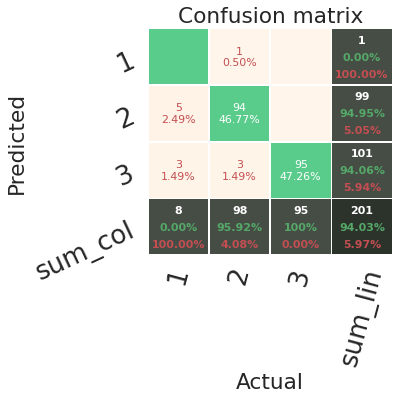

In [ ]:
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "/content/drive/My Drive/Project_try/SaveCM"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
#if not os.path.exists(save_dir):
    #os.makedir(save_dir)
    
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))

#print the confusion matrix :
print (gt_tot)
print (pred_tot)
y_test = np.array(gt_tot)
predic = np.array(pred_tot)
"""
  Examples to validate output (confusion matrix plot)
    actual: 5 and prediction 1   >>  3
    actual: 2 and prediction 4   >>  1
    actual: 3 and prediction 4   >>  10
"""
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.6
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 24;
figsize = [36,36];
if(len(y_test) > 10):
    fz=24; figsize=[36,36];

tp, fp, fn = plot_confusion_matrix_from_data(y_test, predic, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[6,6], show_null_values=0, pred_val_axis='lin')
#tp, fp, fn = plot_confusion_matrix_from_data(y_test, predic, columns = columns, 
 #                                            annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

#return tp, fp, fn

#tp, fp, fn = utils._test_data_class(dataset_val.class_names, gt_tot, pred_tot)
print()

#ap,mrec,mprec=utils.voc_ap(tp, fp, fn)
ap,mrec,mprec= tp,fp, fn



**F1 score**

In [ ]:
# formula F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score_class2 = 2*( 94.95* 95.92) / (94.95 + 95.92)
print(F1_Score_class2)

95.43253523340495


In [ ]:
F1_Score_class3 = 2*( 94.06* 100) / (94.06 + 100)
print(F1_Score_class3)

96.93909100278265


# **Visualization**

In [69]:

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

**GT with predicted region**

image ID: dataset.88 (88) /content/drive/My Drive/Project_try/Dataset/Val/M_image46-3.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   47.00000  max:  416.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8


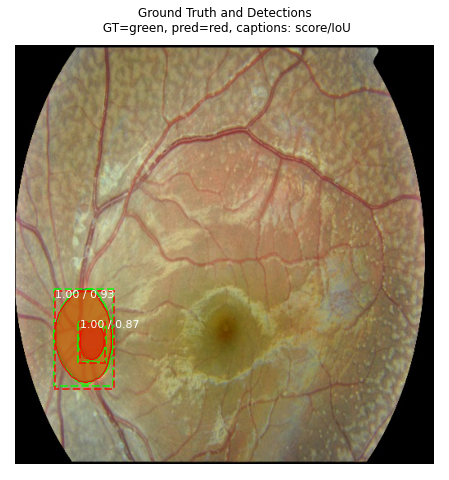

In [70]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'],r['scores'],r['masks'],
                              dataset_val.class_names,ax=ax)

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

**veiw Original image**

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   47.00000  max:  416.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8


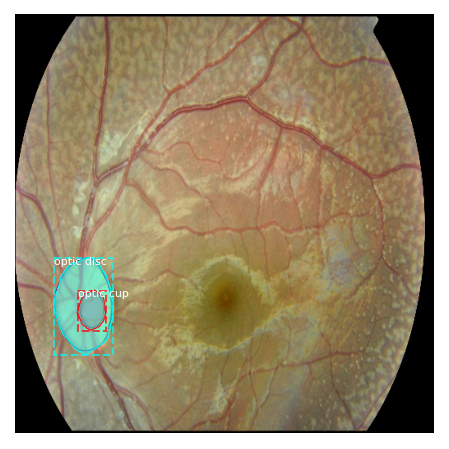

In [71]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

In [72]:
ROOT_DIR = ('/content/drive/My Drive/Project_try')
#os.path.abspath('/content/drive/My Drive/project_try/Mask_RCNN/')
config = GlaucomaCupConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "Dataset")
print(CUSTOM_DIR)

/content/drive/My Drive/Project_try/Dataset


In [ ]:
dataset = GlaucomaDataset()
dataset.load_dataset('/content/drive/My Drive/Project_try/Dataset/Train')

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 476
Class Count: 3
  0. BG                                                
  1. optic cup                                         
  2. optic disc                                        


In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  195 /content/drive/My Drive/Project_try/Dataset/Train/F_image45-2.jpg
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:  187.00000  max:  381.00000  int32


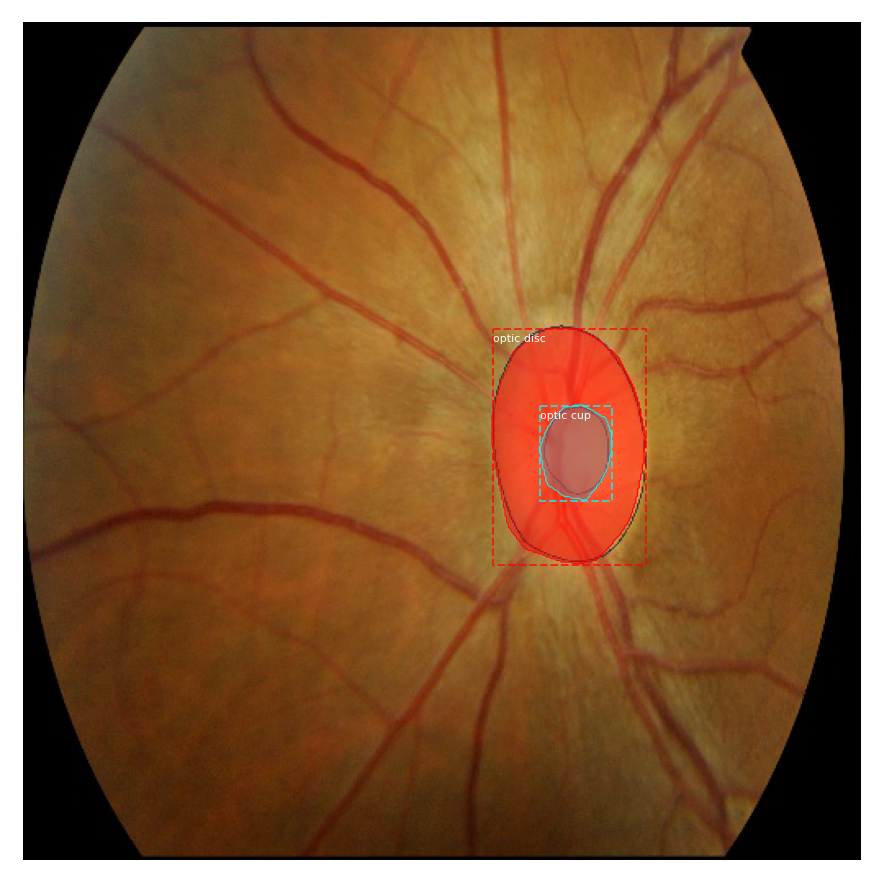

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

**Mini mask**

image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:  172.00000  max:  318.00000  int32
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8


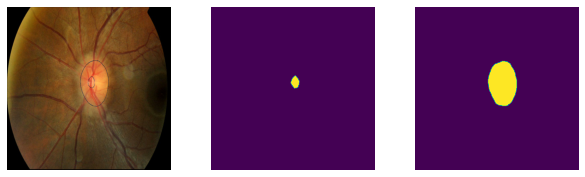

In [ ]:
from mrcnn.visualize import display_images
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

**Mask resizing**

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


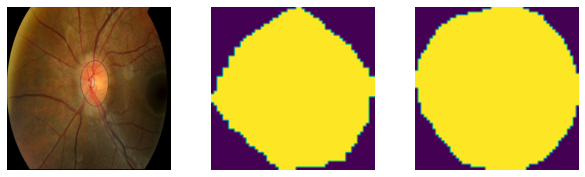

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


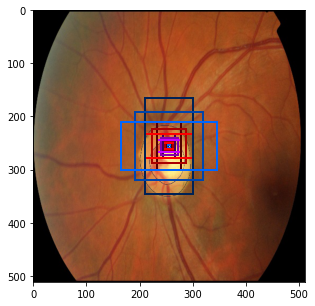

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
import matplotlib.patches as patches
import matplotlib.lines as lines
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


**Data Generator**

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:

# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 32, 4)            min:    2.00000  max:  510.00000  int32
mrcnn_class_ids          shape: (4, 32, 1)            min:    0.00000  max:    2.00000  int32
mrcnn_bbox               shape: (4, 32, 3, 4)         min:   -3.92857  max:    2.89909  float32
mrcnn_mask               shape: (4, 32, 28, 28, 3)    min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 50)               min:    0.00000  max:    2.00000  int32
gt_boxes                 shape: (4, 50, 4)            min:    0.00000  max:  450.00000  int32
gt_masks                 shape: (4, 56, 56, 50)       min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.34375  max:    2.42188  float64
image_id:  267 /content/drive/My Drive/Project_try/Dataset/Train/M_image14-2.jpg


anchors                  shape: (65472, 4)            min:  -90.50967  max:  538.50967  float64
refined_anchors          shape: (2, 4)                min:  195.00000  max:  289.00000  float32
Positive anchors: 2
Negative anchors: 254
Neutral anchors: 65216
BG                     : 22
optic cup              : 2
optic disc             : 8


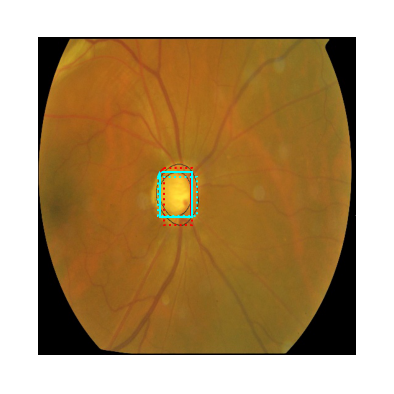

In [ ]:

b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(7, 7))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

In [ ]:
# Show negative anchors

visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

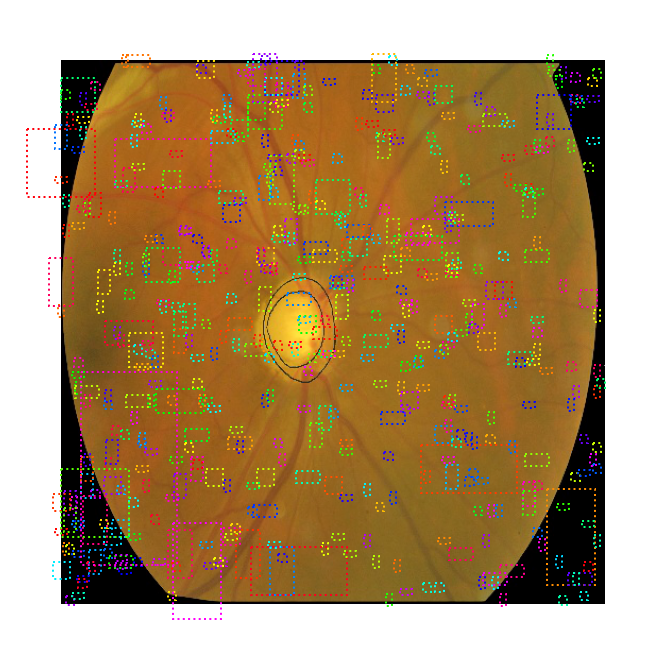

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 500)])

**ROI**

Positive ROIs:  10
Negative ROIs:  22
Positive Ratio: 0.31
Unique ROIs: 32 out of 32


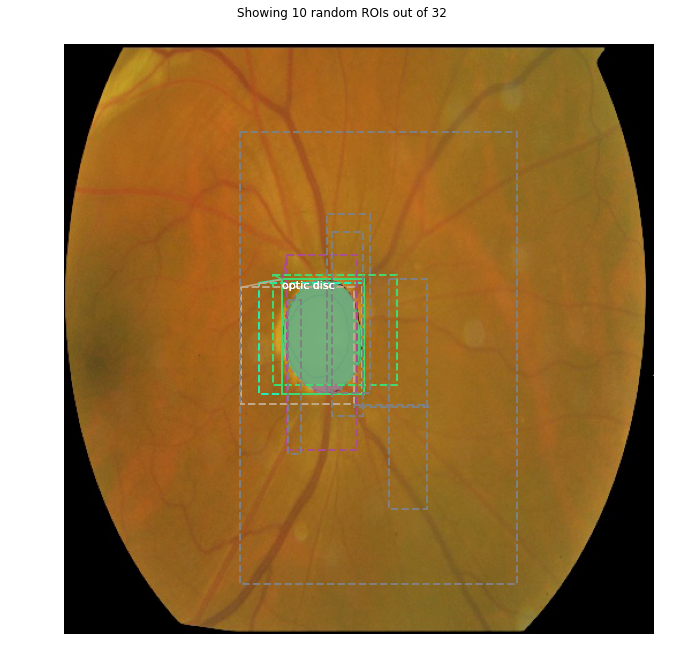

In [ ]:
#@title  { form-width: "110px" }
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

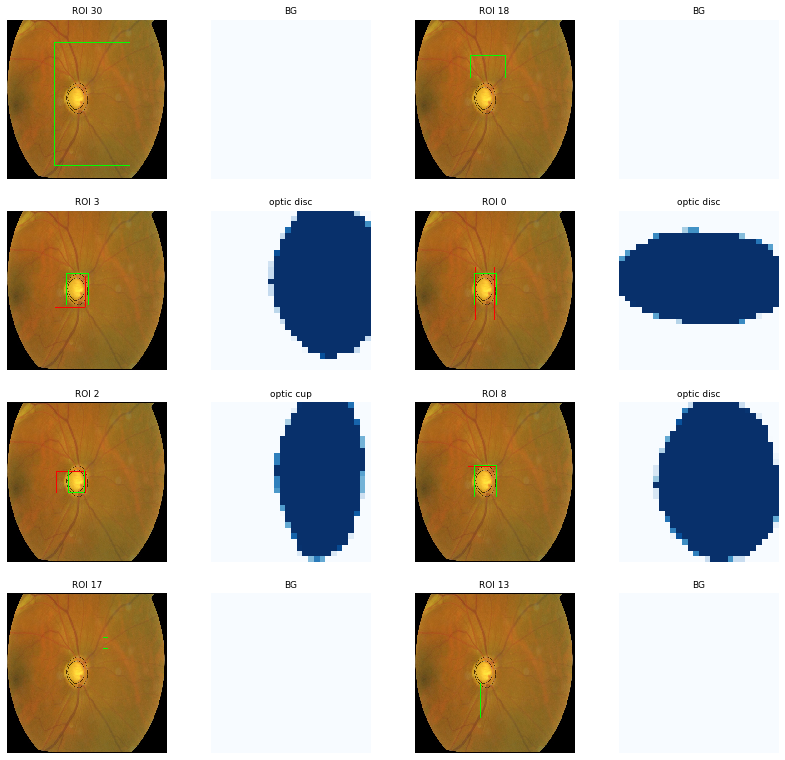

In [ ]:
#@title  { form-width: "110px" }
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")